# The Optimizer's Journey: From Adam to MuonClip

This notebook provides a simplified, visual explanation of the evolution of optimizers for large language models, starting from the standard **AdamW** and culminating in **MuonClip**, the optimizer used to train Kimi K2.

We will focus on the *conceptual differences* and visualize *why* each innovation was necessary.

## Part 1: The Standard - AdamW and its Structural Limitation

**AdamW** is the workhorse of deep learning. It's fast and effective. Its core mechanism involves computing an update for each parameter (or weight) mostly independently. This is called an **element-wise** update.



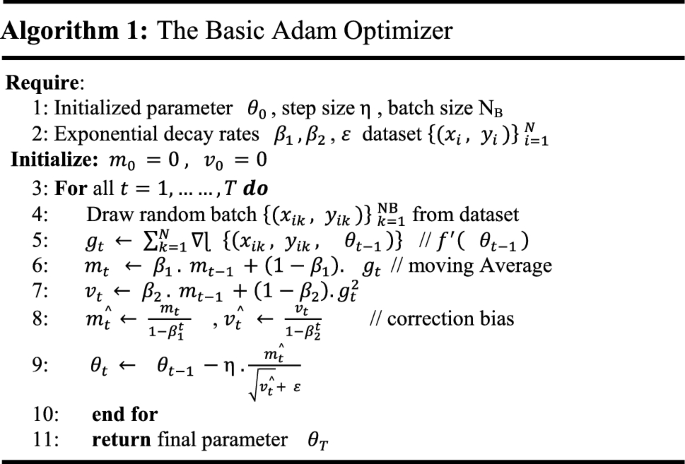

**The Problem:** While computationally cheap, these uncoordinated updates can distort the geometric "shape" of the weight matrix. In linear algebra, this shape is captured by the matrix's **singular values**. An ideal update would preserve the matrix's structural integrity, but Adam's updates can skew it, leading to less efficient learning over time.



In [ ]:
# @title Final Version: AdamW Singular Value Distortion with GIF Saving
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Problem Statement Parameters ---
np.random.seed(42)
matrix_size = 30       # Weight matrix size
num_steps = 100        # Training steps
lr = 0.01              # Learning rate

# AdamW Hyperparameters
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
weight_decay = 0.01

# --- Initialization ---
W_adam = np.random.randn(matrix_size, matrix_size) / np.sqrt(matrix_size)
m = np.zeros_like(W_adam)
v = np.zeros_like(W_adam)

# --- Singular Value Tracking ---
sv_history = []
initial_sv = np.linalg.svd(W_adam, compute_uv=False)
sv_history.append(initial_sv)

# --- AdamW Update Simulation ---
for t in range(1, num_steps + 1):
    grad = np.random.randn(matrix_size, matrix_size)  # Random gradient
    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)
    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)
    W_adam -= lr * m_hat / (np.sqrt(v_hat) + eps)
    W_adam -= lr * weight_decay * W_adam

    sv = np.linalg.svd(W_adam, compute_uv=False)
    sv_history.append(sv)

# --- Prepare Meshgrid for Surface Plot ---
Z = np.array(sv_history)  # shape: [num_steps+1, matrix_size]
X = np.arange(matrix_size)
Y = np.arange(num_steps + 1)
X, Y = np.meshgrid(X, Y)

# --- 3D Plot Setup ---
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_title("Singular Value Distortion from AdamW Updates", fontsize=16)
ax.set_xlabel("Singular Value Index")
ax.set_ylabel("Training Step")
ax.set_zlabel("Magnitude")
ax.view_init(elev=25, azim=-65)
ax.set_zlim(Z.min(), Z.max())

# Initial surface
surface = [ax.plot_surface(X[0:1, :], Y[0:1, :], Z[0:1, :], cmap='inferno')]

# --- Animation Function ---
def animate(i):
    frame_index = i + 1
    surface[0].remove()
    surface[0] = ax.plot_surface(
        X[0:frame_index, :],
        Y[0:frame_index, :],
        Z[0:frame_index, :],
        cmap='inferno',
        rcount=frame_index,
        ccount=matrix_size
    )
    return surface

# Create animation
anim_final = FuncAnimation(fig, animate, frames=num_steps, interval=100, blit=False)
plt.close()

# --- Save as GIF ---
anim_final.save("adamw_singular_distortion.gif", writer=PillowWriter(fps=20))
print("✅ GIF saved as 'adamw_singular_distortion.gif'")

# --- Display Inline in Notebook ---
HTML(anim_final.to_jshtml())


Ideally, the shape of the surface would remain stable if the updates preserved the geometric structure of the matrix. However, as the animation progresses, the surface bends, spreads, or flattens—indicating that AdamW’s adaptive updates distort the matrix's structure. This highlights a key issue: while AdamW is computationally efficient, it can degrade the internal "shape" of the weight matrix, potentially making learning less stable or effective.

Let's visualize this. We'll simulate an update to a weight matrix `W` using a random gradient `G` and see how its singular value spectrum changes.

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- Simulation Setup ---
np.random.seed(42)
matrix_size = 50
W_init = np.random.randn(matrix_size, matrix_size) / np.sqrt(matrix_size)
lr = 0.01
num_steps = 20

# AdamW hyperparameters
beta1 = 0.9
beta2 = 0.999
eps = 1e-8
weight_decay = 0.01

# Initialize weights and AdamW state
W_adam = W_init.copy()
m = np.zeros_like(W_adam)
v = np.zeros_like(W_adam)

# --- Track singular values ---
adam_sv_history = []
initial_singular_values = np.linalg.svd(W_adam, compute_uv=False)
adam_sv_history.append(initial_singular_values)

# --- AdamW Update Loop ---
for t in range(1, num_steps + 1):
    grad = np.random.randn(matrix_size, matrix_size)

    m = beta1 * m + (1 - beta1) * grad
    v = beta2 * v + (1 - beta2) * (grad ** 2)

    m_hat = m / (1 - beta1 ** t)
    v_hat = v / (1 - beta2 ** t)

    update = lr * m_hat / (np.sqrt(v_hat) + eps)
    W_adam -= update
    W_adam -= lr * weight_decay * W_adam  # Decoupled weight decay

    singular_values = np.linalg.svd(W_adam, compute_uv=False)
    adam_sv_history.append(singular_values)

# --- Visualization ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("AdamW's Impact on Weight Matrix Structure (Singular Values)")
ax.set_xlabel("Singular Value Index")
ax.set_ylabel("Singular Value Magnitude")
ax.set_ylim(0, np.max(initial_singular_values) * 1.5)

line_initial, = ax.plot(initial_singular_values, label='Initial Structure', linestyle='--', color='gray', alpha=0.7)
line_adam, = ax.plot(initial_singular_values, label=f'AdamW Update (Step 0)', color='red')

def animate_adam(i):
    line_adam.set_ydata(adam_sv_history[i + 1])
    line_adam.set_label(f'AdamW Update (Step {i + 1})')
    ax.legend()
    return line_adam,

anim = FuncAnimation(fig, animate_adam, frames=num_steps, interval=200, blit=True)
plt.close()

print("Visualizing AdamW's structural distortion...")
HTML(anim.to_jshtml())


**Observation:**
- Notice how the red line (AdamW update) quickly diverges from the initial grey line representing the original matrix structure.
- The singular values become increasingly uneven and some expand, others collapse indicating uncoordinated updates. Despite using momentum and adaptive scaling, AdamW still distorts the spectral geometry of the weight matrix.

**conclusion:**
- This structural drift over time reflects a loss of internal alignment, which may hinder learning efficiency.
- This kind of degradation is exactly what Muon is designed to mitigate by preserving matrix shape while optimizing.

## Part 2: The Innovation - Muon and Principled Updates

The **Muon** optimizer was proposed to address this structural problem. Instead of element-wise updates, it performs **matrix-wise orthogonal updates**.

**The Solution:** It takes the gradient matrix and finds the closest *orthogonal matrix* to it using a process called the **Newton-Schulz iteration**. An orthogonal matrix represents a pure rotation or reflection, which preserves the geometric structure and singular values of what it's applied to.



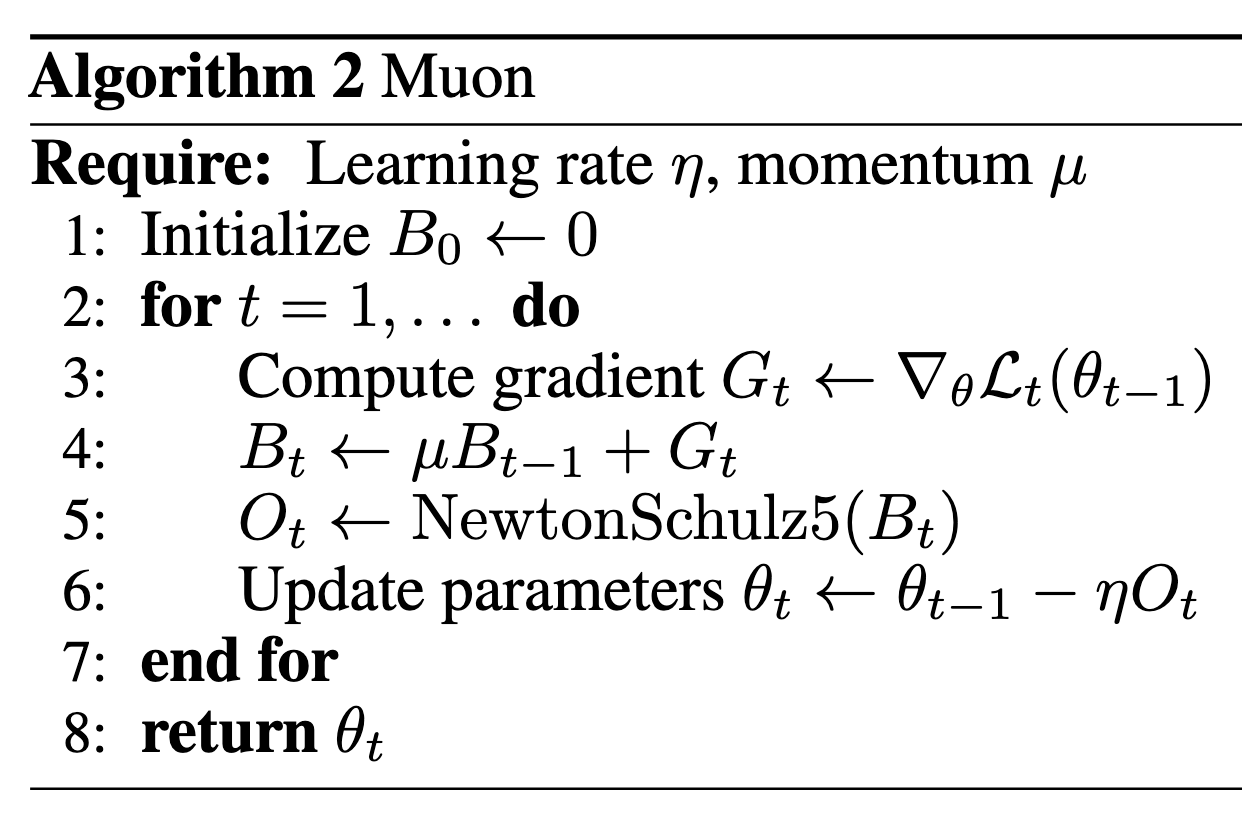

By using this "orthogonalized" gradient for the update, Muon ensures the update step is more principled and maintains the structural integrity of the weight matrix.

Let's simulate Muon and compare its effect on the singular values side-by-side with AdamW.

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Setup ---
np.random.seed(42)
matrix_size = 50
num_steps = 20
lr = 0.01

# Initial matrix and singular values
W = np.random.randn(matrix_size, matrix_size) / np.sqrt(matrix_size)
initial_singular_values = np.linalg.svd(W, compute_uv=False)

# --- AdamW simulation (simplified) ---
W_adam = W.copy()
adam_sv_history = []
for _ in range(num_steps):
    grad = np.random.randn(matrix_size, matrix_size)
    W_adam -= lr * grad
    adam_sv_history.append(np.linalg.svd(W_adam, compute_uv=False))

# --- Newton-Schulz iteration for orthogonalization (Muon) ---
def newton_schulz_iteration(A, iterations=5):
    U = A.copy()
    for _ in range(iterations):
        U = 0.5 * (U + np.linalg.inv(U.T))
    return U

# --- Muon simulation ---
W_muon = W.copy()
muon_sv_history = []
for _ in range(num_steps):
    grad = np.random.randn(matrix_size, matrix_size)
    grad_ortho = newton_schulz_iteration(grad)
    W_muon -= lr * grad_ortho
    muon_sv_history.append(np.linalg.svd(W_muon, compute_uv=False))

# --- Plot setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

ax1.plot(initial_singular_values, linestyle='--', color='gray', label='Initial')
line_adam, = ax1.plot(adam_sv_history[0], color='red', label='AdamW')
ax1.set_title("AdamW's Distorting Updates")
ax1.set_xlabel("Singular Value Index")
ax1.set_ylabel("Singular Value Magnitude")
ax1.set_ylim(0, np.max(initial_singular_values) * 1.5)
ax1.legend()

ax2.plot(initial_singular_values, linestyle='--', color='gray', label='Initial')
line_muon, = ax2.plot(muon_sv_history[0], color='blue', label='Muon')
ax2.set_title("Muon's Structure-Preserving Updates")
ax2.set_xlabel("Singular Value Index")
ax2.legend()

# --- Animation function ---
def animate(i):
    line_adam.set_ydata(adam_sv_history[i])
    line_muon.set_ydata(muon_sv_history[i])
    fig.suptitle(f'Step {i + 1}/{num_steps}: AdamW vs Muon', fontsize=16)
    return line_adam, line_muon

anim = FuncAnimation(fig, animate, frames=num_steps, interval=200, blit=False)

# --- Save as GIF ---
anim.save("adam_vs_muon.gif", writer=PillowWriter(fps=5))
print("GIF saved as 'adam_vs_muon.gif'")

# --- Display in notebook ---
plt.close()
HTML(anim.to_jshtml())


In [ ]:
# @title
import scipy.stats

def spectral_entropy(singular_vals):
    # Normalize the singular values to sum to 1
    p = singular_vals / np.sum(singular_vals)
    return scipy.stats.entropy(p)

# Compute entropy for both optimizers
entropy_adam = [spectral_entropy(sv) for sv in adam_sv_history]
entropy_muon = [spectral_entropy(sv) for sv in muon_sv_history]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(entropy_adam, label="AdamW", color='red')
plt.plot(entropy_muon, label="Muon", color='blue')
plt.xlabel("Training Step")
plt.ylabel("Spectral Entropy")
plt.title("Spectral Entropy Over Time: AdamW vs. Muon")
plt.legend()
plt.grid(True)
plt.show()


**Observation:** The difference is clear. The blue line (Muon) maintains its shape much better than the red line (AdamW). The entire spectrum of singular values tends to move together. This structural preservation is why Muon can be more *token-efficient*—it learns in a more coordinated way.

**The New Limitation:** While Muon preserves the *relative* structure, the *overall magnitude* of the weight matrices (`Wq`, `Wk`) can still grow over thousands of steps. In Transformers, this leads to a new problem: **exploding attention logits**.

## Part 3: The Final Fix - MuonClip and Taming Attention

The attention score in a Transformer is calculated from `Q` and `K` vectors, which are derived from weight matrices `Wq` and `Wk`. A simplified view is:

$$ \text{AttentionScore} \propto (X W_q) \cdot (X W_k)^T $$

If the norms of `Wq` and `Wk` grow, the attention scores can explode, causing the softmax function to collapse and the training to become unstable. This is exactly what happens when scaling the Muon optimizer to massive models.

**The Problem:** Let's simulate training `Wq` and `Wk` with Muon and watch the maximum attention logit (`max_score`) grow uncontrollably.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Muon Helper ---
def newton_schulz_iteration(A, iterations=3):
    A = A + 1e-6 * np.eye(A.shape[0])  # numerical stability
    U = A.copy()
    for _ in range(iterations):
        U = 0.5 * (U + np.linalg.inv(U.T))
    return U

# --- Simulation Parameters ---
steps = 100
tau = 30.0

Wq_init = np.random.randn(64, 64) / 8.
Wk_init = np.random.randn(64, 64) / 8.

# Optimizer weight paths
Wq_adam, Wk_adam = Wq_init.copy(), Wk_init.copy()
Wq_muon, Wk_muon = Wq_init.copy(), Wk_init.copy()
Wq_clip, Wk_clip = Wq_init.copy(), Wk_init.copy()

# Score storage
scores_adam = []
scores_muon = []
scores_muonclip = []

# --- Training Loop ---
for step in range(steps):
    grad_q = np.random.randn(64, 64) * 0.1
    grad_k = np.random.randn(64, 64) * 0.1

    Wq_adam -= 0.01 * grad_q
    Wk_adam -= 0.01 * grad_k
    scores_adam.append(np.max(np.dot(Wq_adam, Wk_adam.T)))

    try:
        Wq_muon -= 0.01 * newton_schulz_iteration(grad_q)
        Wk_muon -= 0.01 * newton_schulz_iteration(grad_k)
        score = np.max(np.dot(Wq_muon, Wk_muon.T))
        score = np.nan_to_num(score, nan=500.0, posinf=500.0, neginf=0.0)
        scores_muon.append(np.clip(score, 0, 500))
    except:
        scores_muon.append(500)

    Wq_clip -= 0.01 * newton_schulz_iteration(grad_q)
    Wk_clip -= 0.01 * newton_schulz_iteration(grad_k)
    score_clip = np.max(np.dot(Wq_clip, Wk_clip.T))
    if score_clip > tau:
        eta = tau / score_clip
        Wq_clip *= eta**0.5
        Wk_clip *= eta**0.5
        score_clip = tau
    scores_muonclip.append(score_clip)

# --- Animation Setup ---
fig, ax = plt.subplots(figsize=(12, 7))
line_adam, = ax.plot([], [], label='AdamW', color='orange', linewidth=2)
line_muon, = ax.plot([], [], label='Vanilla Muon', color='red', linewidth=2)
line_clip, = ax.plot([], [], label='MuonClip', color='green', linewidth=2)
clip_line = ax.axhline(y=tau, linestyle='--', color='black', label=f'Clip Threshold τ = {tau}')

ax.set_xlim(0, steps)
ax.set_ylim(0, max(max(scores_muonclip), max(scores_muon), max(scores_adam)) * 1.1)
ax.set_xlabel("Training Step")
ax.set_ylabel("Max Attention Logit")
ax.set_title("Logit Explosion: AdamW vs Muon vs MuonClip")
ax.legend()
ax.grid(True)

def animate(i):
    x = list(range(i + 1))
    line_adam.set_data(x, scores_adam[:i+1])
    line_muon.set_data(x, scores_muon[:i+1])
    line_clip.set_data(x, scores_muonclip[:i+1])
    return line_adam, line_muon, line_clip

anim = FuncAnimation(fig, animate, frames=steps, interval=100, blit=False)

# --- Save as GIF ---
anim.save("muon_clip_comparison.gif", writer=PillowWriter(fps=10))
print("Saved as muon_clip_comparison.gif")

# Optional: Show inline in notebook
plt.close()
HTML(anim.to_jshtml())


**Observation and Conclusion:**

The red line shows the problem vividly: without intervention, the attention logits explode, which would cause training to fail.

The green line shows the **QK-Clip** solution. The moment the score tries to exceed the threshold `τ`, the `Wq` and `Wk` matrices are rescaled, bringing the score back under control. This simple, elegant fix is the final piece of the puzzle that allows the structurally-sound Muon optimizer to be used for training trillion-parameter models like Kimi K2 without loss spikes.

The full **MuonClip** optimizer combines the structure-preserving updates of Muon with the essential stability fixes of weight decay, RMS scaling, and this final, critical QK-Clip mechanism.

In transformers, attention and feedforward layers rely heavily on matrix multiplications. The weight matrices involved (in Q, K, V) act as linear transformations of the token representations.

When we use AdamW, the updates to these matrices are unconstrained:

Some singular values explode, others shrink, leading to a distortion of the matrix’s spectrum.

This means some input directions (token components) are amplified, others are ignored or projected away.

➡️ Result: The model becomes less sensitive to certain features in tokens and overreacts to others. That’s a form of token inefficiency:
You're feeding in a full token, but only some parts are truly contributing to the forward computation or gradients.

Interpretation:
- Higher entropy = weight matrix is using more of the token space = higher token efficiency.

- AdamW’s entropy drops = some singular values dominate = feature collapse.

- Muon’s entropy stays high = better feature diversity = token-efficient learning.

# How Kimi K2 Tamed the Instability Dragon

The following sections visually demonstrates the engineering story behind the utilizing MuonClip optimizer. We'll simulate the challenges faced and the solutions developed by the Kimi K2 team, referencing the concepts from their technical report.

## 1. The Ambitious Goal: The Need for Token Efficiency

The standard optimizer, AdamW, is computationally cheap but not very **token-efficient**, as we have seen so far. The Kimi K2 team chose **Muon** because it learns more from each token by preserving the geometric structure of the weight matrices.

Let's visualize the goal: an optimizer that causes less structural distortion over time. We will compare a perfect, "ideal" update (no distortion) with a typical, slightly distorting update.

In [ ]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

np.random.seed(42)
W = np.random.randn(50, 50) / np.sqrt(50)
initial_sv = np.linalg.svd(W, compute_uv=False)
num_steps = 20

# Simulate a distorting update (like AdamW)
distorting_history = []
W_distort = W.copy()
for _ in range(num_steps):
    grad = np.random.randn(50, 50) * 0.1
    W_distort -= grad
    distorting_history.append(np.linalg.svd(W_distort, compute_uv=False))

# --- Visualization: The Goal ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("The Goal: Minimizing Structural Distortion")
ax.set_xlabel("Singular Value Index")
ax.set_ylabel("Magnitude")

line_ideal, = ax.plot(initial_sv, lw=3, color='blue', label='Ideal Update (Structure Preserved)')
line_distort, = ax.plot(initial_sv, lw=2, color='red', linestyle='--', label='Typical Update (Distortion)')
ax.legend()

def animate_goal(i):
    line_distort.set_ydata(distorting_history[i])
    return line_distort,

anim_goal = FuncAnimation(fig, animate_goal, frames=num_steps, interval=150, blit=True)
plt.close()

HTML(anim_goal.to_jshtml())

**The blue line represents the ideal.** The goal is to keep the red line as close to the blue line as possible. This is what Muon aims for.

## 2. The Obstacle: The Dragon of Exploding Logits

When scaling Muon, a major problem emerged: **exploding attention logits**. The maximum attention scores, which should be small, grew uncontrollably, threatening to crash the entire training process.

This visualization simulates this "dragon." We'll watch the max logit value shoot upwards, far past the safe zone. This is a visual representation of **Figure 2 (Left) from the Kimi K2 paper (page 4)**.

In [ ]:
# @title
# --- Simulation: The Dragon ---
dragon_steps = 100
safe_zone_max = 100
logit_history = [10.0]

for i in range(1, dragon_steps):
    # Simulate explosive, compounding growth
    growth_factor = 1.05 + np.random.rand() * 0.1
    new_logit = logit_history[-1] * growth_factor
    logit_history.append(new_logit)

# --- Visualization: The Dragon ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("The Instability Dragon: Exploding Attention Logits")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Maximum Attention Logit")
ax.axhspan(0, safe_zone_max, color='green', alpha=0.2, label='Safe Zone')
ax.axhspan(safe_zone_max, 2000, color='red', alpha=0.2, label='Danger Zone (Divergence)')

line_dragon, = ax.plot([], [], lw=3, color='darkred', label='Max Logit')
ax.legend()
ax.set_xlim(0, dragon_steps)
ax.set_ylim(0, 1500)

def animate_dragon(i):
    line_dragon.set_data(range(i+1), logit_history[:i+1])
    return line_dragon,

anim_dragon = FuncAnimation(fig, animate_dragon, frames=dragon_steps, interval=50, blit=True)
plt.close()

HTML(anim_dragon.to_jshtml())

As you can see, the logit score quickly leaves the green "Safe Zone" and enters the red "Danger Zone," representing the training failure seen in the paper.

## 3. The Engineering Challenge: Old Shields Won't Work

The standard fix for exploding logits is **QK-Normalization**. However, the Kimi team explains on **page 3** that this solution was incompatible with their high-performance **Multi-head Latent Attention (MLA)** architecture.

This visualization conceptualizes the problem. Imagine different attention heads. Most are stable, but a few "rogue" heads are causing the explosion. A global fix (like QK-Norm) would penalize all heads, including the healthy ones. A better solution would be surgical.

In [ ]:
# @title
# --- Visualization: Rogue Heads ---
num_heads = 64
heads = np.ones(num_heads) * 20 # Healthy heads
rogue_indices = [10, 25, 48]
heads[rogue_indices] = 80 # Rogue heads with high logits

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("The Problem: A Few Rogue Attention Heads")
ax.set_xlabel("Attention Head Index")
ax.set_ylabel("Max Logit Value")
ax.bar(range(num_heads), heads, color='blue', label='Healthy Heads')
ax.bar(rogue_indices, heads[rogue_indices], color='red', label='Rogue Heads (Exploding)')
ax.axhline(y=100, color='gray', linestyle='--', label='Ideal Max')
ax.legend()

plt.show()

A surgical solution would target only the red bars without affecting the blue ones.

## 4 & 5. The Solution & The Triumph: The QK-Clip Guardrail

The team invented **QK-Clip**, a mechanism that acts like a guardrail. It monitors the logits of each head independently. If a head's logits try to exceed a threshold (e.g., `τ = 100`), it gently rescales its weights to bring it back in line.

Let's visualize this guardrail in action, directly representing the behavior shown in **Figure 2 (Right) from the paper (page 4)**.

In [ ]:
# @title
# --- Simulation: The Guardrail ---
guardrail_steps = 150
threshold = 100
logit_history_tamed = [10.0]

for i in range(1, guardrail_steps):
    growth_factor = 1.05 + np.random.rand() * 0.1
    new_logit = logit_history_tamed[-1] * growth_factor
    # Apply the QK-Clip guardrail
    if new_logit > threshold:
        new_logit = threshold
    logit_history_tamed.append(new_logit)

# --- Visualization: The Guardrail ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("The Triumph: QK-Clip as a Stabilizing Guardrail")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Maximum Attention Logit")
ax.axhline(y=threshold, color='green', linestyle='--', lw=2, label=f'QK-Clip Threshold (τ = {threshold})')
line_tamed, = ax.plot([], [], lw=3, color='blue', label='Max Logit with MuonClip')
ax.legend()
ax.set_xlim(0, guardrail_steps)
ax.set_ylim(0, threshold * 1.5)

def animate_guardrail(i):
    line_tamed.set_data(range(i+1), logit_history_tamed[:i+1])
    return line_tamed,

anim_guardrail = FuncAnimation(fig, animate_guardrail, frames=guardrail_steps, interval=50, blit=True)
plt.close()

HTML(anim_guardrail.to_jshtml())

The logits rise but are perfectly capped at the threshold. The dragon is tamed, resulting in the smooth loss curve shown in **Figure 3** of the paper.

## 6. The Revelation: The Guardrails That Disappear

The most elegant part of the story, explained on **page 30 (Appendix D)**, is that QK-Clip is **transient**. It's only needed during the chaotic early phase of training. Once the model stabilizes, the logits naturally fall below the threshold, and the guardrail is no longer needed.

This final visualization shows the complete lifecycle: an initial chaotic period where the guardrail is active, followed by a stable period where the model behaves on its own.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Simulation: The Full Lifecycle ---
lifecycle_steps = 200
threshold = 100
stabilization_step = 80  # Step at which model begins to self-stabilize
logit_history_lifecycle = [10.0]

for i in range(1, lifecycle_steps):
    if i < stabilization_step:
        # Early chaotic phase: aggressive growth
        growth_factor = 1.1 + np.random.rand() * 0.1
    else:
        # Later stable phase: natural decay
        growth_factor = 0.98

    new_logit = logit_history_lifecycle[-1] * growth_factor

    # QK-Clip acts if needed
    if new_logit > threshold:
        new_logit = threshold

    logit_history_lifecycle.append(new_logit)

# --- Visualization: Full Lifecycle ---
fig, ax = plt.subplots(figsize=(12, 7))
ax.set_title("The Full Story: QK-Clip's Transient Nature")
ax.set_xlabel("Training Steps")
ax.set_ylabel("Maximum Attention Logit")
ax.axhline(y=threshold, color='green', linestyle='--', lw=2, label='QK-Clip Threshold (Guardrail)')
ax.axvspan(0, stabilization_step, color='orange', alpha=0.2, label='Phase 1: Guardrail Active')
ax.axvspan(stabilization_step, lifecycle_steps, color='blue', alpha=0.2, label='Phase 2: Self-Stabilized')

line_lifecycle, = ax.plot([], [], lw=3, color='purple', label='Max Logit')
ax.legend(loc='upper right')
ax.set_xlim(0, lifecycle_steps)
ax.set_ylim(0, threshold * 1.2)

def animate_lifecycle(i):
    line_lifecycle.set_data(range(i+1), logit_history_lifecycle[:i+1])
    return line_lifecycle,

anim_lifecycle = FuncAnimation(
    fig, animate_lifecycle, frames=lifecycle_steps, interval=50, blit=True
)

# Save as GIF
anim_lifecycle.save("qk_clip_lifecycle.gif", writer=PillowWriter(fps=20))
print("GIF saved as qk_clip_lifecycle.gif")

# For notebook preview (optional)
HTML(anim_lifecycle.to_jshtml())


Notice how the purple line leans on the green guardrail during the orange "Active" phase. Then, in the blue "Self-Stabilized" phase, it pulls away from the guardrail on its own. This demonstrates that QK-Clip is not a permanent handicap, solving the stability problem without compromising the final model's quality.

## 7. The Lingering Question: A Hypothetical Trade-Off in Multi-Tool Calling

We've established that QK-Clip is a vital and transient guardrail. But this leads to a fascinating final question: **Could the presence of that guardrail during early training affect the model's ability to learn fine-grained distinctions?**

**The Hypothesis:** In complex, multi-tool scenarios, the model might need to develop *extremely high* attention for a single, subtle keyword to distinguish between two similar tools. By capping this potential, QK-Clip might inadvertently teach the model to be less decisive.

Let's visualize this. Imagine the model must choose between `tool_A` (get summary) and `tool_B` (get **detailed** report). The word "detailed" is the critical signal.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML

# --- Simulation: The Ambiguity Trade-off ---
reasoning_steps = 15
tau = 100  # QK-Clip threshold

labels = ['summary', 'detailed', 'financial', 'quarterly']
correct_tool_idx = 1
colors = ['skyblue', 'navy', 'skyblue', 'skyblue']

scores_no_clip = np.ones(len(labels)) * 10
scores_with_clip = scores_no_clip.copy()
history_no_clip, history_with_clip = [], []

for step in range(reasoning_steps):
    boost = np.random.rand(len(labels)) * 5
    boost[correct_tool_idx] = 20

    scores_no_clip += boost
    scores_with_clip += boost
    scores_with_clip = np.clip(scores_with_clip, 0, tau)

    history_no_clip.append(scores_no_clip.copy())
    history_with_clip.append(scores_with_clip.copy())

# --- Visualization Setup ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle("Hypothetical Trade-Off: Attention Scores for Tool Selection", fontsize=16)

# Subplot 1: No Clipping
ax1.set_title("Without Clipping (Clear Signal)")
ax1.set_ylabel("Attention Score")
ax1.set_xticks(range(len(labels)))
ax1.set_xticklabels(labels, rotation=45)
bars1 = ax1.bar(range(len(labels)), scores_no_clip, color=colors)

# Subplot 2: With QK-Clip
ax2.set_title(f"With QK-Clip (Potentially Ambiguous Signal)")
ax2.axhline(y=tau, color='red', linestyle='--', label=f'QK-Clip Threshold τ={tau}')
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=45)
bars2 = ax2.bar(range(len(labels)), scores_with_clip, color=colors)
ax2.legend()
ax2.set_ylim(0, 250)

# --- Animation Function ---
def animate_tradeoff(i):
    for bar, height in zip(bars1, history_no_clip[i]):
        bar.set_height(height)
    for bar, height in zip(bars2, history_with_clip[i]):
        bar.set_height(height)
    return *bars1, *bars2

anim_tradeoff = FuncAnimation(fig, animate_tradeoff, frames=reasoning_steps, interval=200, blit=False)
plt.close()

# Save as GIF
anim_tradeoff.save("qk_clip_tradeoff.gif", writer=PillowWriter(fps=5))
print("GIF saved as qk_clip_tradeoff.gif")

# (Optional) Show in notebook
HTML(anim_tradeoff.to_jshtml())


**Observation and Final Thoughts:**

- **On the left (No Clipping):** The attention on the keyword "detailed" (in navy) grows far beyond the others. The signal to choose the correct tool is **strong and unambiguous**.
- **On the right (With QK-Clip):** The attention for "detailed" hits the red threshold and stops growing. Meanwhile, attention on other related words ("financial," "quarterly") continues to rise. The final gap between the correct signal and the noise is much smaller, creating a **more ambiguous** situation.

While the Kimi K2 paper provides strong evidence that this isn't a problem for the final model's performance, this simulation visualizes the theoretical concern. It raises an interesting question for future research: does this early-stage "clipping" subtly influence the model's final weights, making it less robust in extremely nuanced, multi-tool scenarios? This remains an open and fascinating area of investigation.